# Make Calibration WAV Files
## By Terry Bondy, VA3TYB

In [1]:
printf(strftime ("Last updated: %A %e %B %Y %Z", localtime (time())))
%plot --format svg
# format long

Last updated: Sunday 29 December 2019 UTC

In [2]:
fcLow = 200;
fcHigh = 2600;

In [3]:
fcMid = sqrt(fcHigh/fcLow) * fcLow

fcMid =  721.11


In [4]:
F = fcLow:1:fcHigh;
columns(F)
sqrt(fcLow*fcHigh)

ans =  2401
ans =  721.11


In [5]:
J = log(F);
jmin = min(J)
jmax = max(J)
jmid = mean([jmin, jmax])
H = abs(J - jmid);
hmin = min(H)
hmax = max(H)

jmin =  5.2983
jmax =  7.8633
jmid =  6.5808
hmin =    1.5291e-04
hmax =  1.2825


In [6]:
# What are the factors of the number of frequencies?
Factors = factor(columns(F)-1);
# Determine the possible intervals by looking at all products of choose
Possible_Intervals = unique(cell2mat(arrayfun(@(t) unique(prod(nchoosek(Factors, t), 2))', [1:columns(Factors)], "UniformOutput", false)))
# Then pick one of them
intervals = Possible_Intervals(9)

Possible_Intervals =

 Columns 1 through 11:

      2      3      4      5      6      8     10     12     15     16     20

 Columns 12 through 22:

     24     25     30     32     40     48     50     60     75     80     96

 Columns 23 through 33:

    100    120    150    160    200    240    300    400    480    600    800

 Columns 34 and 35:

   1200   2400

intervals =  15


Sort F so that it is in the order log distance from fcMid, and also compute what interval they are in.

In [7]:
G = sortrows(horzcat(H', ceil(intervals*H'/hmax), F'), [1]);

Sample a number of rows

In [8]:
format long g
Sample = vertcat(G(1:floor(end/intervals):end,:), G(rows(G),:))
format

Sample =

  0.000152907993856033                     1                   721
     0.111291697227823                     2                   806
     0.220490989192815                     3                   899
     0.326963233703332                     4                   520
     0.430421942071562                     6                  1109
     0.529904077700022                     7                  1225
     0.624843131131558                     8                  1347
     0.714323988345509                     9                   353
     0.800048529486476                    10                   324
     0.880348471888118                    11                   299
     0.956774539091467                    12                   277
      1.02907015563475                    13                  2018
      1.09753431122808                    13                  2161
       1.1624776555502                    14                  2306
      1.22420577060679                    15        

In [9]:
G(find(G(:,3)==721),:)

ans =

   1.5291e-04   1.0000e+00   7.2100e+02



In [10]:
sum(G(:,2) == 1)
sum(G(:,2) == 1:1:intervals)

ans =  123
ans =

 Columns 1 through 13:

   123   125   126   129   132   138   142   151   156   167   176   188   201

 Columns 14 and 15:

   215   232



Ensure that there are no values of H that are duplicated, meaning that there are a pair of frequencies, one each on each side of fcMid, that are equidistant log-wise, from fcMid. If there are, then we would have to be careful how we subdivide F later on. If there is at least one, then the following result will be zero.

In [11]:
sort(abs(diff(H)))(1)

ans =    3.8469e-04


Helps that fcMid is not integral, like members of F.

In [12]:
TestFreq = G(:,3);
iter = 0;
filename = sprintf("TestFreq.mat", iter);
save(filename,"TestFreq");
# save "TestFreq.mat" TestFreq;

In [13]:
sampleRate = 16000;
numPeriods = 10;
period = numPeriods;
Tshort = 0:1/sampleRate:1;
T = 0:1/sampleRate:period;

Ensure that you run `Nonlin_min_Install` notebook to install this package.

In [14]:
pkg load optim

In [15]:
# TestPhi is a column vector, 0 <= phi <= pi, length m
# TestFreq is a column vector, length m
# Sig is a row vector
# Tshort is a row vector
function cost = costAny(Phi_trial, CosTerm, Sig)
  cost = max(abs(sum(cos(CosTerm + Phi_trial)) + Sig));
endfunction

In [16]:
tic = time();
TestFreq = [ G(1,3) ];
TestPhi = [ 0 ];
cosArg = 2*pi*TestFreq * Tshort + TestPhi;
Sig = cos(cosArg);
size(Sig)
max(abs(Sig))
printf("toc: %d seconds\n", time() - tic)
max(abs(Sig))
numIndexes = 16;
iter=1;
for firstIndex = 2:numIndexes:rows(G)
  TestFreq = G(firstIndex:firstIndex+numIndexes-1, 3);
  CosTerm = 2*pi*TestFreq * Tshort;
  tic = time();
  
  init_p = pi*rand(rows(TestFreq),1);
  lbound = zeros(rows(TestFreq), 1);
  ubound = pi .* ones(rows(TestFreq), 1);
  [TestPhi, objf, cvg] = nonlin_min (@ (Phi_trial) costAny(Phi_trial, CosTerm, Sig), init_p, optimset ("Algorithm", "samin", 
    "lbound", lbound,
    "ubound", ubound,
    "Display", "iter"
  ));
  printf("toc: %d seconds\n", time() - tic)
  cosArg = 2*pi*TestFreq * Tshort + TestPhi;
  Sig = sum(cos(cosArg)) + Sig;
  size(Sig)
  max(abs(Sig))
  filename = sprintf("TestFreq_%d.mat", iter);
  save(filename, "TestFreq");
  filename = sprintf("TestPhi_%d.mat", iter);
  save(filename, "TestPhi");
  filename = sprintf("Sig_%d.mat", iter);
  save(filename, "Sig");
  iter++;
endfor

ans =

       1   16001

ans =  1
toc: 0.0228541 seconds
ans =  1
temperature no. 1: 1.000000e-01, energy 5.675907e+00,
tries with energy less / not less but accepted / rejected: / to far / new optimum
358 / 345 / 897 / 343 / 29
temperature no. 2: 1.000000e+01, energy 8.238079e+00,
tries with energy less / not less but accepted / rejected: / to far / new optimum
767 / 811 / 22 / 728 / 0
temperature no. 3: 8.333333e+00, energy 1.264205e+01,
tries with energy less / not less but accepted / rejected: / to far / new optimum
757 / 799 / 44 / 772 / 0
temperature no. 4: 6.944444e+00, energy 1.093103e+01,
tries with energy less / not less but accepted / rejected: / to far / new optimum
767 / 797 / 36 / 803 / 0
temperature no. 5: 5.787037e+00, energy 1.179500e+01,
tries with energy less / not less but accepted / rejected: / to far / new optimum
773 / 772 / 55 / 828 / 0





In [17]:
Sig(1)
Sig(end)
tic = time();
# Repeat Sig to expand it to numPeriods
Sig = [(Sig(1:end-1)' * ones(1, numPeriods))(:)', Sig(1)];
printf("toc: %d seconds\n", time() - tic)

ans =  1
ans =  1
toc: 0.0114112 seconds


In [18]:
tic = time();
# SigShort = Sig(1:end-1);
# Sig = [SigShort, SigShort, SigShort, SigShort, SigShort, SigShort, SigShort, SigShort, SigShort, Sig];
printf("toc: %d seconds\n", time() - tic)

toc: 0.00869989 seconds


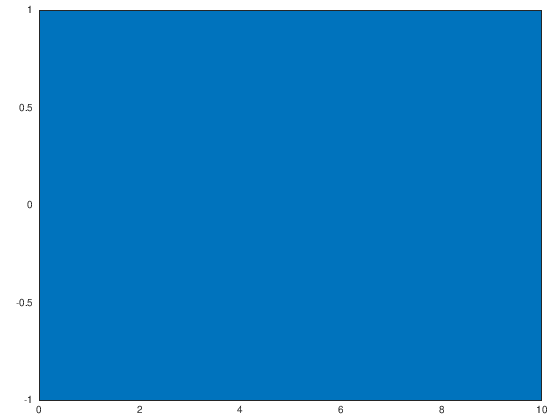

In [19]:
# size(Tshort)
# size(T)
# size(Sig)
plot(T, Sig)
# grid on
# grid minor
# axis([-0.1,+0.1], "tic")

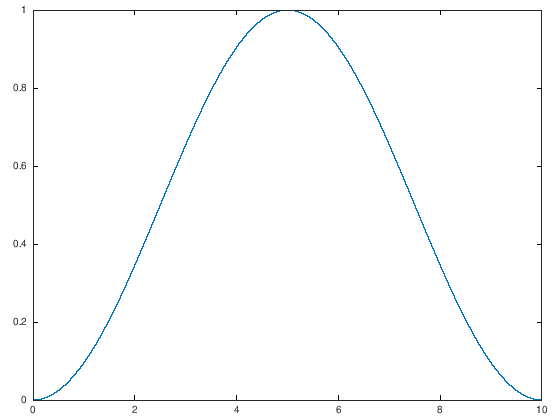

In [20]:
RC = (1 - cos(2*pi*T/period))/2;
plot(T, RC);

In [21]:
E_cos_pulse = fftshift(fft(RC .* Sig, sampleRate*period*10 + 1));
# E_cos_pulse = fftshift(fft(RC .* Sig));
F_base = linspace(-sampleRate/2, sampleRate/2, columns(E_cos_pulse));

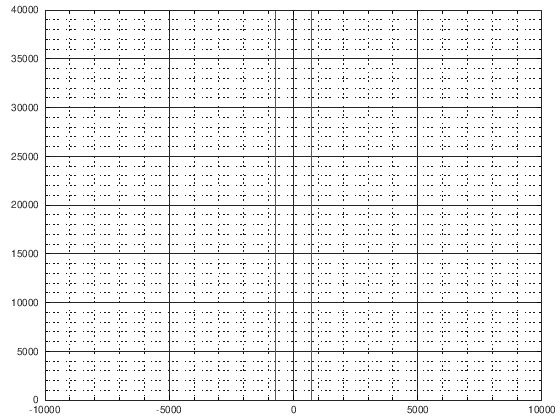

In [22]:
plot(F_base, abs(E_cos_pulse))
grid on
grid minor
# axis([fcLow-10 fcLow+10], "tic")

In [23]:
# This is a test